# Aula 8 - árvore de decisão

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Introdução
- 2) Árvores de decisão
- 6) Árvores de regressão

____
____
____

## 1) Árvores de decisão

Estrutura de uma árvore de decisão:

<img src="https://i1.wp.com/www.vooo.pro/insights/wp-content/uploads/2016/12/RDS-Vooo_insights-Tutorial_arvore_de_decisao_02.jpg?resize=640%2C371&ssl=1" width=600>

**Alguns exemplos:**

<img src="https://web.tecnico.ulisboa.pt/ana.freitas/bioinformatics.ath.cx/bioinformatics.ath.cx/uploads/RTEmagicC_arv_dec4_01.gif.gif" width=500>


<img src="https://didatica.tech/wp-content/uploads/2020/07/image-3.png" width=500>

Já vimos árvores de decisão anteriormente no curso, no módulo de estrutura de dados.

Naquele contato, nós criamos árvores **instanciando a classe com a estrutura que desejávamos**.

Agora, conheceremos árvores como **estimadores**, de modo que á arvore **irá determinar sua estrutura com base nos dados de treino**!

Isto é, a árvore irá determinar **quais são as melhores quebras** a serem feitas em cada nó.

Entenderemos mais a frente como a "qualidade" de uma quebra é quantificada.

Antes, vamos construir um modelo de árvore na prática!

In [1]:
# importe as principais bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

Para o exemplo de árvore de descisão iremos utilizar um [dataset de risco de crédito](https://www.kaggle.com/uciml/german-credit). 

O objetivo é determinar a quais clientes será concedido crédito, com base em diversas features.

Esta base é clássica, e muito utilizada, mas simplifica consideravelmente o processo de risco de crédito. Na vida real, este problema é tratado utilizando diversas informações, de diferentes fontes. Para uma ideia da complexidade real do problema, sugiro dar uma olhada [nesta competição](https://www.kaggle.com/c/home-credit-default-risk/data).

In [2]:
df = pd.read_csv("../datasets/german_credit_data.csv", index_col=0)

In [3]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [5]:
df_model = df.select_dtypes(include=np.number)

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Age            1000 non-null   int64
 1   Job            1000 non-null   int64
 2   Credit amount  1000 non-null   int64
 3   Duration       1000 non-null   int64
dtypes: int64(4)
memory usage: 39.1 KB


In [7]:
df_model

,Age,Job,Credit amount,Duration
0,67,2,1169,6
1,22,2,5951,48
2,49,1,2096,12
3,45,2,7882,42
4,53,2,4870,24
...,...,...,...,...
995,31,1,1736,12
996,40,3,3857,30
997,38,2,804,12
998,23,2,1845,45


In [8]:
df_model = pd.concat([df_model, df["Risk"]], axis=1)

In [9]:
df_model

,Age,Job,Credit amount,Duration,Risk
0,67,2,1169,6,good
1,22,2,5951,48,bad
2,49,1,2096,12,good
3,45,2,7882,42,good
4,53,2,4870,24,bad
...,...,...,...,...,...
995,31,1,1736,12,good
996,40,3,3857,30,good
997,38,2,804,12,good
998,23,2,1845,45,bad


Há um desbalanço considerável no target, mas, por enquanto, não vamos nos preocupar em endereçar isso na partida. Vamos apenas garantir que a proporção é mantida após o train-test split, quando formos fazê-lo


In [10]:
df_model["Risk"].value_counts(normalize=True)

good    0.7
bad     0.3
Name: Risk, dtype: float64

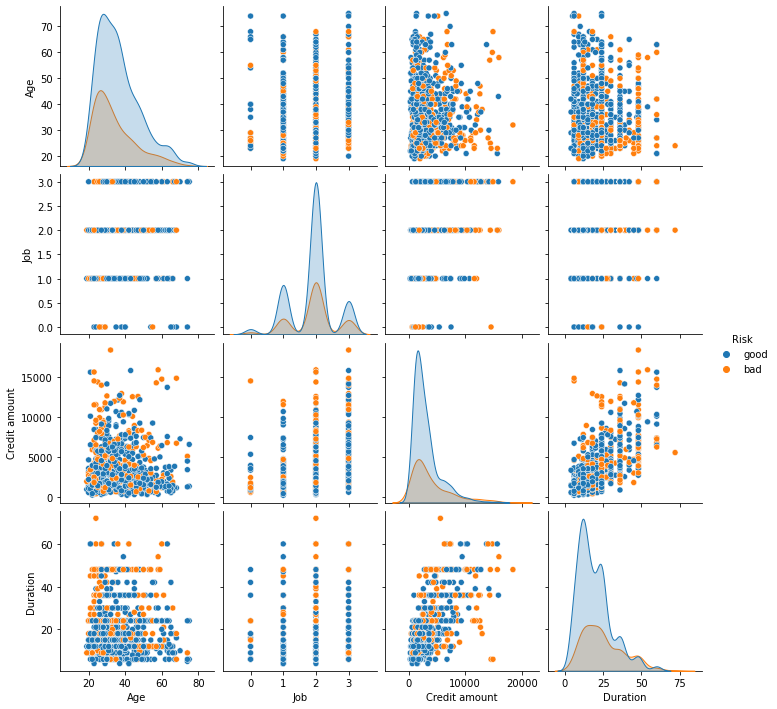

In [11]:
sns.pairplot(data=df_model, hue="Risk")

Temos duas colunas com dados missing. Como vimos no módulo 3, é importante que estes missing sejam tratados adequadamente: ou que estas linhas sejam **deletadas**, ou que os **dados nulos sejam preenchidos**. 

Na primeira versão de nosso modelo, vamos dropar todas as linhas com missing (e, além disso, vamos utilizar apenas as features numéricas).

Vamos construir um classificador de árvore de decisão, cuja classe é a [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [12]:
X = df_model.drop(columns="Risk")
y = df_model["Risk"]

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
y_train.value_counts(normalize=True)

good    0.7
bad     0.3
Name: Risk, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

good    0.7
bad     0.3
Name: Risk, dtype: float64

In [16]:
df_model.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


### Só pra testar com o logit...

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression


Métricas de avaliação de treino:
[[ 29 211]
 [ 19 541]]


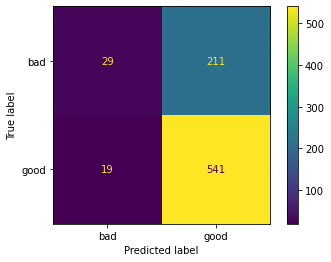

              precision    recall  f1-score   support

         bad       0.60      0.12      0.20       240
        good       0.72      0.97      0.82       560

    accuracy                           0.71       800
   macro avg       0.66      0.54      0.51       800
weighted avg       0.68      0.71      0.64       800


Métricas de avaliação de teste:
[[  4  56]
 [  7 133]]


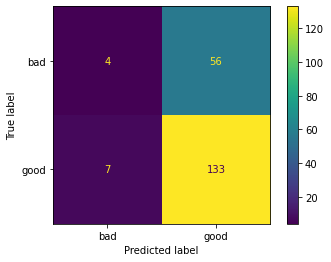

              precision    recall  f1-score   support

         bad       0.36      0.07      0.11        60
        good       0.70      0.95      0.81       140

    accuracy                           0.69       200
   macro avg       0.53      0.51      0.46       200
weighted avg       0.60      0.69      0.60       200



In [18]:
# ============================================

lr = LogisticRegression().fit(X_train, y_train)

# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = lr.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = lr.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

Agora, pra árvore:

In [19]:
from sklearn.tree import DecisionTreeClassifier


Métricas de avaliação de treino:
[[240   0]
 [  0 560]]


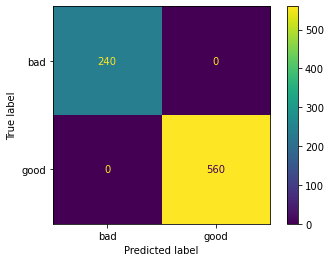

              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       240
        good       1.00      1.00      1.00       560

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Métricas de avaliação de teste:
[[ 23  37]
 [ 40 100]]


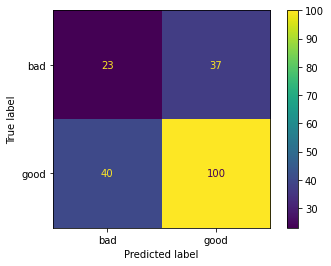

              precision    recall  f1-score   support

         bad       0.37      0.38      0.37        60
        good       0.73      0.71      0.72       140

    accuracy                           0.61       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.62      0.61      0.62       200



In [20]:
# ============================================

dt = DecisionTreeClassifier().fit(X_train, y_train)

# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = dt.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = dt.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

Temos um claro overfitting! 

Por que isso pode ter acontecido? Vamos discutir mais sobre isso adiante, mas o fato é que o método de árvore de decisão é um método notoriamente **propenso a overfitting**.

Para entender o porquê, vamos dar uma olhada na árvore treinada!

__Visualizando a árvore de decisão__

É possível visualizar a árvore de decisão criada com o próprio sklearn!

Para isso, basta usar a função `plot_tree()` do sub-módulo tree, conforme abaixo!

Para mais detalhes sobre como plotar a árvore, [clique aqui](https://scikit-learn.org/stable/modules/tree.html#tree)

In [21]:
from sklearn.tree import plot_tree

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 18), dpi=300)

plot_tree(dt);

#fig.savefig("arvore1.png")

In [23]:
X_train.columns

Index(['Age', 'Job', 'Credit amount', 'Duration'], dtype='object')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 18), dpi=800)

plot_tree(dt, feature_names=X_train.columns);

#fig.savefig("arvore1.png")

Alguns métodos interessantes da árvore:

In [25]:
dt.get_depth()

19

In [26]:
dt.get_n_leaves()

232

Temos uma árvore **muito profunda**, o que implica em um **modelo muito complexo**.

De fato, se imaginarmos a hipótese como uma função definida por partes, quanto mais quebras, mais partes, o que torna a hipótese mais complexa, e, portanto, mais propensa a overfitting!

Uma visualização do que acontece com o espaço de features:

<img src=https://paulvanderlaken.files.wordpress.com/2020/03/readme-titanic_plot-11.png width=500>

Antes de avançarmos na direção de melhoria deste cenário, vamos parar e entender um pouco mais a fundo como que o estimador de árvore de decisão funciona!

_______

Agora que vimos na prática o modelo de árvore de decisão, vamos entender como **a árvore é construída com base nos dados de treino**!

__Exemplo__

Digamos que uma amostra de 30 alunos tem duas variáveis: Sexo (menino ou menina), Turma (IX ou X). 

Digamos também que 15 destes 30 jogam tênis no recreio. 

A árvore de decisão segregará os alunos com base nos valores das variáveis e **identificará a variável que cria os melhores conjuntos homogêneos de alunos** quanto ao target: quem joga tênis, e quem não joga.

Toda árvore começa pelo nó raiz, então, uma pergunta natural é: **qual feature utilizamos para fazer a quebra do nó raiz: sexo ou turma?**

Há duas quebras possíveis:

<img src="https://i2.wp.com/www.vooo.pro/insights/wp-content/uploads/2016/12/RDS-Vooo-Tutorial_completo_arvore_decisao_03.jpg?resize=617%2C293&ssl=1" width=500>

Vemos que, **dependendo da feature que utilizamos pra fazer a quebra**, conseguimos **graus de separações diferentes dos dados com relação ao target**:


<table>
<thead>
  <tr>
    <th colspan="4"><center>Sexo</center></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td colspan="2"><center>Meninas</center></td>
    <td colspan="2"><center>Meninos</center></td>
  </tr>
  <tr>
    <td><center>jogam tênis</center></td>
    <td><center>NÃO jogam tênis</center></td>
    <td><center>jogam tênis</center></td>
    <td><center>NÃO jogam tênis</center></td>
  </tr>
  <tr>
    <td><center>2</center></td>
    <td><center>8</center></td>
    <td><center>13</center></td>
    <td><center>7</center></td>
  </tr>
  <tr>
    <td colspan="2"><center>10</center></td>
    <td colspan="2"><center>20</center></td>
  </tr>
</tbody>
</table>


<table>
<thead>
  <tr>
    <th colspan="4"><center>turma</center></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td colspan="2"><center>IX</center></td>
    <td colspan="2"><center>X</center></td>
  </tr>
  <tr>
    <td><center>jogam tênis</center></td>
    <td><center>NÃO jogam tênis</center></td>
    <td><center>jogam tênis</center></td>
    <td><center>NÃO jogam tênis</center></td>
  </tr>
  <tr>
    <td><center>6</center></td>
    <td><center>8</center></td>
    <td><center>9</center></td>
    <td><center>7</center></td>
  </tr>
  <tr>
    <td colspan="2"><center>14</center></td>
    <td colspan="2"><center>16</center></td>
  </tr>
</tbody>
</table>

Como decidir qual das quebrar acima **separou melhor os dados com relação ao target?**

Matematicamente, o modelo pode usar dois critérios diferentes para decidir como fazer as quebras na árvore: o **critério de Gini** ou o **critério da entropia**.

______

**Critério de Gini**

A **impureza de Gini** mede o quão "impuras" são as folhas das árvores construídas após as quebras nos nós. O coeficiente é dado por:

$$Gini(D) = 1 - \sum{p_{i}^2}$$

Onde $p_i$ são as **proporções** de separação do target em cada quebra.

Aqui estaremos interessados **em como a impureza muda após as quebras**. Nosso objetivo será **maximizar a purificação proporcionada pela quebra nos nós** -- mais precisamente, estamos interessados em determinar **qual é a quebra que proporciona a maior purificação**.

- **Impureza antes da divisão**: Como não havia separação alguma, a impureza era dada simplesmente pelo balanço natural dos dados: 

$$G(\text{pré-divisão}) = 1 - ((15/30)^2 + (15/30)^2) = 0.5$$

Temos duas quebras possíveis:

- Divisão por **sexo**: após a divisão dos dados pela feature **sexo**, passamos a ter as seguintes impurezas, segundo a tabela acima: 

    - $G(\text{meninas}) = 1 - (\frac{2}{10}^2 + \frac{8}{10}^2) = 0.319$
    
    - $G(\text{meninos}) = 1 - ( \frac{13}{20}^2 + \frac{7}{20}^2) = 0.454$
    
    Ou seja, após a divisão, a impureza total passa a ser a média ponderada: 
    
    <br>
    
    - $G(\text{pós-divisão}) = \frac{10}{30} \times G(\text{meninas}) + \frac{20}{30} \times G(\text{meninos})
    = 0.33 \times 0.319 + 0.66 \times 0.454
    = 0.40491$
    
    Assim, **a perda de impureza proporcionada pela quebra** dos dados segundo a feature **sexo** é de:
    
    <br>
    
    - $\Delta G_{\text{sexo}} = G(\text{pré-divisão}) - G(\text{pós-divisão}) = 0.5 - 0.40491 = $ **0.095**
    
    
<br> 

- Divisão por **classe**: após a divisão dos dados pela feature **classe**, passamos a ter as seguintes impurezas, segundo a tabela acima:

    - $G(\text{IX}) = 1 - (\frac{6}{14}^2 + \frac{8}{14}^2) = 0.489$
    
    - $G(\text{X}) = 1 - ( \frac{9}{16}^2 + \frac{7}{16}^2) = 0.492$
    
    Ou seja, após a divisão, a impureza total passa a ser a média ponderada: 
    
    <br>
    
    - $G(\text{pós-divisão}) = \frac{14}{30} \times G(\text{IX}) + \frac{16}{30} \times G(\text{X})
    = 0.46 \times 0.489 + 0.53 \times 0.492
    = 0.4857$
    
    Assim, **a perda de impureza proporcionada pela quebra** dos dados segundo a feature **classe** é de:
    
    <br>
    
    - $\Delta G_{\text{classe}} = G(\text{pré-divisão}) - G(\text{pós-divisão}) = 0.5 - 0.4857 = $ **0.014**
 

 
Agora, como escolher a melhor quebra?

> O **critério de Gini** consiste em **escolher a quebra que proporciona a maior perda de impureza**, ou, equivalentemente, **a maior purificação**.

Assim, a divisão a ser escolhida seria por **sexo**. 

Depois, aplica-se o mesmo procedimento para os nós resultantes.

_________

**Critério de entropia**

A **entropia** é uma quantidade definida em física e teoria da informação com o objetivo de quantificar **o grau de desordem de um sistema**, ou, equivalentemente, **o quanto de informação se tem sobre determinado sistema**.

A entropia é dada por:

 $$E = -\sum{p_{i} \times \log_{2}{p_{i}}}$$
 
Onde $p_i$ são as **proporções** de separação do target em cada quebra.

Aqui estaremos interessados **em como a impureza muda após as quebras**. 
 
Aqui também estaremos interessados **em como a entropia muda após as quebras**. Nosso objetivo será **maximizar o ganho de informação proporcionado pela quebra nos nós** -- mais precisamente, estamos interessados em determinar **qual é a quebra que proporciona o maior ganho de informação**.

- **Entropia antes da divisão**: 

$$E(pré-divisão) = \frac{15}{10}log_{2}{\frac{15}{10}} + \frac{15}{10}log_{2}{\frac{15}{10}} = 1$$


Temos duas quebras possíveis:

- Divisão por sexo: 

    - $E(\text{meninas}) = -1 \times (\frac{2}{10} \log_{2}\frac{2}{10} + \frac{8}{10} \log_{2}\frac{8}{10}) = 0.721$
    - $E(\text{meninos}) = -1 \times (\frac{13}{20} \log_{2}\frac{13}{20} + \frac{7}{20} \log_{2}\frac{7}{20}) = 0.934$
    
    A entropia ponderada após a divisão por **sexo** é:
    
    <br>
    
    - $E(\text{pós-divisão}) = \frac{10}{30} \times E(\text{meninas}) + \frac{20}{30} \times E(\text{meninos}) =  0.863$
    
    Assim, o ganho de informação após a divisão por **sexo** é:
    
    <br>
    
    - $\Delta E_{\text{sexo}} = E(\text{pré-divisão}) - E(\text{pós-divisão}) = 1 - 0.863 =$ **0.137**

<br>

- Divisão por classe:

    - $E(\text{IX}) = -1 \times (\frac{6}{14} \log_{2}\frac{6}{14} + \frac{8}{14} \log_{2}\frac{8}{14}) = 0.985$
    - $E(\text{X}) = -1 \times (\frac{9}{16} \log_{2}\frac{9}{16} + \frac{7}{16} \log_{2}\frac{7}{16}) = 0.988$
    
    A entropia ponderada após a divisão por **classe** é:
    
    <br>
    
    - $E(\text{pós-divisão}) = \frac{10}{30} \times E(\text{IX}) + \frac{20}{30} \times E(\text{X}) =  0.986$
    
    Assim, o ganho de informação após a divisão por **classe** é:
    
    <br>
    
    - $\Delta E_{\text{classe}} = E(\text{pré-divisão}) - E(\text{pós-divisão}) = 1 - 0.986 =$ **0.014**

Também pela entropia, a divisão a ser escolhida seria por **sexo**. 

Depois, aplica-se o mesmo procedimento para os nós resultantes, até obter-se nós puros.

____

__Qual a diferença entre os dois critérios?__

A origem, e pequenas diferenças computacionais. 

Apesar das medidas serem semelhantes, é possível que haja sim diferenças nos resultados gerados por cada um deles!

<img src="https://qph.fs.quoracdn.net/main-qimg-3f3484dc9513748c3283fa0d1d996e82" width=600>

Como dica geral: teste ambos! O Grid Search pode sempre nos ajudar a determinar qual dos dois é mais adequado em cada caso!

E, além do critério pro split, temos alguns outros hiperparâmetros muito importantes para a árvore de decisão, sobretudo no que diz respeito à sua **regularização**: `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_leaf_nodes`, `min_impurity_decrease`, `ccp_alpha`.

Vamos então treinar um modelo melhor?

Vamos usar o que aprendemos na aula passada e já usar o Grid Search!

_________________

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold

pipe = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42))
])
parameters = {
    'dt__criterion' : ['gini','entropy'],
    'dt__splitter' : ['best','random'],
    'dt__max_depth' : range(2,11)
}

splitter = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

grid_dt = GridSearchCV(
                        estimator = pipe,
                        param_grid = parameters,
                        scoring = 'f1_weighted',
                        cv = splitter,
                        verbose = 1
)

In [28]:
grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': range(2, 11),
                         'dt__splitter': ['best', 'random']},
             scoring='f1_weighted', verbose=1)

In [29]:
grid_dt.best_params_

{'dt__criterion': 'gini', 'dt__max_depth': 2, 'dt__splitter': 'best'}

In [30]:
grid_dt.best_estimator_['dt']

DecisionTreeClassifier(max_depth=2, random_state=42)


Métricas de avaliação de treino:
[[ 40 200]
 [ 14 546]]


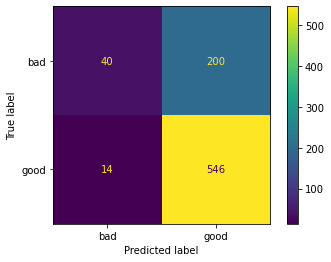

              precision    recall  f1-score   support

         bad       0.74      0.17      0.27       240
        good       0.73      0.97      0.84       560

    accuracy                           0.73       800
   macro avg       0.74      0.57      0.55       800
weighted avg       0.73      0.73      0.67       800


Métricas de avaliação de teste:
[[  9  51]
 [  6 134]]


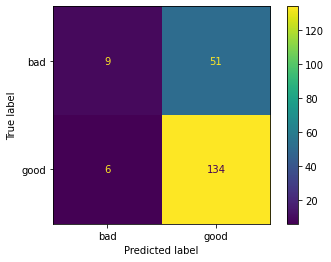

              precision    recall  f1-score   support

         bad       0.60      0.15      0.24        60
        good       0.72      0.96      0.82       140

    accuracy                           0.71       200
   macro avg       0.66      0.55      0.53       200
weighted avg       0.69      0.71      0.65       200



In [31]:
print("\nMétricas de avaliação de treino:")

y_pred_train = grid_dt.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = grid_dt.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

Muito melhor, não é mesmo! E longe de estar overfitado!

Veja, como o modelo agora está bem mais simples:

_________

Uma outra forma de buscar por hiperparâmetros é através **de uma busca aleatória**, o que pode ser feito através do [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

<img src="https://www.yourdatateacher.com/wp-content/uploads/2021/03/image-7.png" width=400>

A diferença entre este buscador e o GridSearch, é que neste caso não explicitamos a lista com os valores dos hiperparâmetros a serem combinados, mas passamos **os valores possíveis dos hiperparâmetros, que são amostrados aleatoriamente de modo a gerar combinações aleatórias!** 

Aí, ao invés de tentarmos todas as combinações possíveis, testamos apenas **um número determinado de combinações aleatoriamente amostradas das distribuições!**

<img src=https://miro.medium.com/max/1004/0*yDmmJmvRowl0cSN8.png width=400>

Para mais informações sobre este método, [clique aqui!](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search).

[Veja aqui](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html) uma comparação entre os dois métodos.

Em algumas situações, pode ser que a busca aleatória seja mais eficiente que o grid search, dado seu caráter aleatório!

In [33]:
import scipy

scipy.stats.uniform(0,1)

In [34]:
from sklearn.model_selection import RandomizedSearchCV

parameters_dist = {
    'dt__criterion' : ['gini','entropy'],
    'dt__splitter' : ['best','random'],
    'dt__min_impurity_decrease' : scipy.stats.uniform(0,1)
}

splitter = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

grid_dt_random = RandomizedSearchCV(
                        estimator = pipe,
                        param_distributions = parameters_dist,
                        n_iter = 100,
                        scoring = 'f1_weighted',
                        cv = splitter,
                        verbose = 1
)

grid_dt_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('dt',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_iter=100,
                   param_distributions={'dt__criterion': ['gini', 'entropy'],
                                        'dt__min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1269f99a0>,
                                        'dt__splitter': ['best', 'random']},
                   scoring='f1_weighted', verbose=1)

In [35]:
grid_dt_random.best_params_

{'dt__criterion': 'gini',
 'dt__min_impurity_decrease': 0.020693106216696067,
 'dt__splitter': 'best'}


Métricas de avaliação de treino:


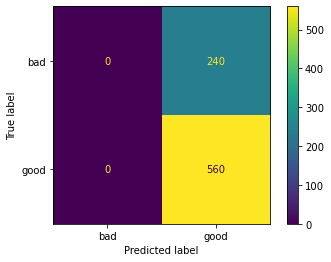

              precision    recall  f1-score   support

         bad       0.00      0.00      0.00       240
        good       0.70      1.00      0.82       560

    accuracy                           0.70       800
   macro avg       0.35      0.50      0.41       800
weighted avg       0.49      0.70      0.58       800


Métricas de avaliação de teste:
[[  0  60]
 [  0 140]]


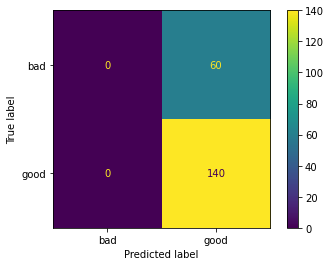

              precision    recall  f1-score   support

         bad       0.00      0.00      0.00        60
        good       0.70      1.00      0.82       140

    accuracy                           0.70       200
   macro avg       0.35      0.50      0.41       200
weighted avg       0.49      0.70      0.58       200



In [36]:
print("\nMétricas de avaliação de treino:")

y_pred_train = grid_dt_random.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()
print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = grid_dt_random.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()
print(classification_report(y_test, y_pred_test))

In [40]:
grid_dt_random.best_estimator_['dt'].get_depth(), grid_dt_random.best_estimator_['dt'].get_n_leaves()

(0, 1)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits

Métricas de avaliação de treino:


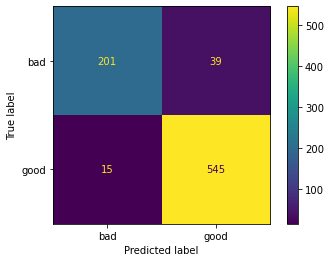

              precision    recall  f1-score   support

         bad       0.93      0.84      0.88       240
        good       0.93      0.97      0.95       560

    accuracy                           0.93       800
   macro avg       0.93      0.91      0.92       800
weighted avg       0.93      0.93      0.93       800


Métricas de avaliação de teste:
[[ 20  40]
 [ 31 109]]


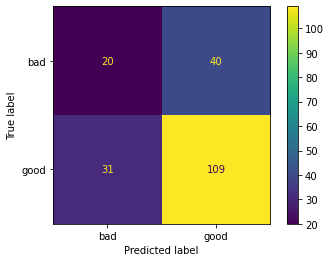

              precision    recall  f1-score   support

         bad       0.39      0.33      0.36        60
        good       0.73      0.78      0.75       140

    accuracy                           0.65       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.63      0.65      0.64       200



In [51]:
parameters_dist = {
    'dt__criterion' : ['gini','entropy'],
    'dt__splitter' : ['best','random'],
    'dt__min_impurity_decrease' : scipy.stats.uniform(0,0.001)
}

grid_dt_random = RandomizedSearchCV(
                        estimator = pipe,
                        param_distributions = parameters_dist,
                        n_iter = 1000,
                        scoring = 'f1_weighted',
                        cv = splitter,
                        verbose = 1
)

grid_dt_random.fit(X_train, y_train)

print("\nMétricas de avaliação de treino:")

y_pred_train = grid_dt_random.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()
print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = grid_dt_random.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()
print(classification_report(y_test, y_pred_test))

In [52]:
grid_dt_random.best_estimator_['dt'].get_depth(), grid_dt_random.best_estimator_['dt'].get_n_leaves()

(18, 136)

In [53]:
grid_dt_random.best_params_

{'dt__criterion': 'gini',
 'dt__min_impurity_decrease': 0.0008123606533622168,
 'dt__splitter': 'best'}

In [56]:
pd.DataFrame(grid_dt_random.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__min_impurity_decrease,param_dt__splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004602,0.000909,0.001837,0.000648,gini,0.000812,best,"{'dt__criterion': 'gini', 'dt__min_impurity_de...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,1
658,0.004023,0.000643,0.001943,0.000453,entropy,0.000961,random,"{'dt__criterion': 'entropy', 'dt__min_impurity...",1.0,NaN,NaN,NaN,NaN,NaN,NaN,2
659,0.005443,0.000639,0.002355,0.000704,entropy,0.000021,best,"{'dt__criterion': 'entropy', 'dt__min_impurity...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,3
660,0.006505,0.000918,0.002031,0.000847,entropy,0.000418,best,"{'dt__criterion': 'entropy', 'dt__min_impurity...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,4
661,0.004872,0.000621,0.001858,0.000842,gini,0.000486,best,"{'dt__criterion': 'gini', 'dt__min_impurity_de...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,5
662,0.003600,0.000519,0.001588,0.000457,gini,0.000573,random,"{'dt__criterion': 'gini', 'dt__min_impurity_de...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,6
663,0.005840,0.000904,0.002030,0.000547,entropy,0.000256,best,"{'dt__criterion': 'entropy', 'dt__min_impurity...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,7
664,0.003577,0.000215,0.001861,0.000383,entropy,0.000965,random,"{'dt__criterion': 'entropy', 'dt__min_impurity...",1.0,NaN,NaN,NaN,NaN,NaN,NaN,8
665,0.004119,0.000741,0.002015,0.000591,entropy,0.000747,random,"{'dt__criterion': 'entropy', 'dt__min_impurity...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,9
666,0.004825,0.000586,0.001934,0.000276,gini,0.000615,best,"{'dt__criterion': 'gini', 'dt__min_impurity_de...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,10


Conseguimos zerar o recall (mas a um custo muito alto: estamos predizendo apenas "good"!)

Certamente seria interessante mudar este comportamento. Como lição de casa, tente otimizar métricas diferentes! 

> Uma boa dica: parar estimadores com muitos hiperparâmetros, ou então hiperparâmetros em que é difícil chutar bons valores, utilizar o **random search** para explorar inicialmente o espaço; e depois partir para o **grid search** nas regiões promissoras!

_________________

## 6) Árvores de regressão

Alguns algoritmos de classificação podem ser utilizados como algoritmos de regressão, inclusive árvores de decisão!

As **árvores de regressão** consistem em funções com valores discretos, similar a uma escada, onde cada degrau é o valor de uma folha. [Aqui](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) há detalhes sobre a classe do sklearn; e [aqui](https://www.youtube.com/watch?v=g9c66TUylZ4) está o StatQuest sobre árvores de regressão!

Considere o seguinte dataset:

<img src='https://s3-sa-east-1.amazonaws.com/lcpi/800a4332-e709-4ea3-8c24-959c05c8fd65.png' width=500>

O algoritmo irá obter os valores do target como sendo **a média dos valores de cada folha da árvore final**. 

Visualmente: 

<img src='https://s3-sa-east-1.amazonaws.com/lcpi/64cb4edd-20e1-486a-8fc9-60e60e1485d5.png' width=500>

Para a escolha das melhores divisões: 

- o algoritmo percorre a médida entre cada par de pontos das features; 
- define estes valores como divisões (sequencialmente); 
- para cada divisão experimentada, o algoritmo calcula o MSE;
- a melhor divisão é aquela que apresentar o menor erro!

Visualmente:

<img src='https://s3-sa-east-1.amazonaws.com/lcpi/be58ac8b-5c59-4b9f-be79-e000d060e9e3.png' width=500>

<img src='https://s3-sa-east-1.amazonaws.com/lcpi/1f317afd-6119-41a5-849d-cee038403cf2.png' width=500>

Outro exemplo de árvore de regressão treinada (note a aparência da hipótese -- são "setores", que em uma única dimensão parecem com degraus):

<img src="https://res.cloudinary.com/practicaldev/image/fetch/s--YryIJN_o--/c_imagga_scale,f_auto,fl_progressive,h_900,q_auto,w_1600/https://thepracticaldev.s3.amazonaws.com/i/7oxf0e3cggdj9jayxeig.png" width=600>

Vamos fazer um modelo de árvore de regressão para precificação de casas!

A classe é [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [59]:
df = pd.read_csv("../datasets/house_prices.csv")

df = df.select_dtypes(include=[np.number])
df = df.dropna(axis="columns", how="any")

X = df.drop(columns=["Id","SalePrice"])
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold


pipeline = Pipeline([
    ('dt', DecisionTreeRegressor(random_state=42))
])

param_grid_reg = {
    'dt__criterion' : ['squared_error','friedman_mse','absolute_error', 'poisson'],
    'dt__splitter' : ['best','random'],
    'dt__max_depth' : range(2,11)
}

splitter = KFold(n_splits=5, shuffle=True, random_state=42)

grid_dt_reg = GridSearchCV(
                        estimator =  pipeline,
                        param_grid = param_grid_reg,
                        scoring = 'neg_mean_absolute_error',
                        cv = splitter,
                        verbose = 1
)

grid_dt_reg.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('dt',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'dt__criterion': ['squared_error', 'friedman_mse',
                                           'absolute_error', 'poisson'],
                         'dt__max_depth': range(2, 11),
                         'dt__splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error', verbose=1)

In [62]:
grid_dt_reg.best_params_

{'dt__criterion': 'squared_error', 'dt__max_depth': 9, 'dt__splitter': 'best'}

In [61]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# predições de treino
y_pred_train = grid_dt_reg.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

# predições de teste
y_pred_test = grid_dt_reg.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 


Métricas de treino:

R^2: 0.98
MAE: 7703.06
RMSE: 11021.02

Métricas de teste:

R^2: 0.73
MAE: 26505.79
RMSE: 45444.58


In [63]:
pd.DataFrame(grid_dt_reg.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,param_dt__splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.018090,0.005984,0.006377,0.007139,squared_error,9,best,"{'dt__criterion': 'squared_error', 'dt__max_de...",-24202.222152,-24437.793837,-27537.289747,-27802.361723,-22881.340664,-25372.201625,1951.391446,1
32,0.012282,0.001652,0.003031,0.000766,friedman_mse,9,best,"{'dt__criterion': 'friedman_mse', 'dt__max_dep...",-24202.222152,-24437.793837,-27537.289747,-27802.361723,-22881.340664,-25372.201625,1951.391446,1
13,0.008029,0.001941,0.005741,0.002488,squared_error,8,random,"{'dt__criterion': 'squared_error', 'dt__max_de...",-24704.796370,-28160.286722,-24485.368004,-24912.800554,-25554.895947,-25563.629519,1346.590177,3
31,0.004929,0.000670,0.002660,0.000817,friedman_mse,8,random,"{'dt__criterion': 'friedman_mse', 'dt__max_dep...",-24704.796370,-28160.286722,-24485.368004,-24912.800554,-25554.895947,-25563.629519,1346.590177,3
10,0.013440,0.001888,0.002759,0.000934,squared_error,7,best,"{'dt__criterion': 'squared_error', 'dt__max_de...",-25883.713423,-25411.672661,-27715.205957,-26996.485102,-21942.381209,-25589.891670,1995.890363,5


Usando as métricas do Rank #3

In [64]:
pipeline = Pipeline([
    ('dt', DecisionTreeRegressor(criterion='squared_error', max_depth = 6, splitter='best', random_state=42))
])

pipeline.fit(X_train, y_train)

# predições de treino
y_pred_train = grid_dt_reg.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

# predições de teste
y_pred_test = grid_dt_reg.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 



Métricas de treino:

R^2: 0.98
MAE: 7703.06
RMSE: 11021.02

Métricas de teste:

R^2: 0.73
MAE: 26505.79
RMSE: 45444.58


Conseguimos fazer coisas bem melhores com a regressão linear regularizada!

Mas, é legal saber que agora temos mais uma técnica para explorar!!

Para casa: itere mais algumas vez no gridsearch com a árvore de decisão. Tente chegar no melhor modelo possível!